In [1]:
import numpy as np 

from yt_idv.coordinate_utilities import (
    SphericalMixedCoordBBox,
    cartesian_bboxes,
    cartesian_bboxes_edges, # from edges 
    cartesian_to_spherical,
    spherical_to_cartesian,
)
import matplotlib.pyplot as plt 

yt conventions for spherical coordinates:

* r : radius
* theta: colatitude, 0 to pi
* phi: azimuth (longitudinal angle), 0 to 2pi

In [2]:
bbox_handler = SphericalMixedCoordBBox()

set some ray cases, single elements, select which to use.

Note that in order to create visualizations easily, the element should span the equator (theta=pi/2) over a very narrow range. this allows an almost 2d element, and we can plot in 2d... the intersections below are calculated in 3d (though not the initial bounding box...) but visualized in 2d.

i_ray = 3, i_el = 0 is a nice place to start.

In [3]:
ray_cases = [
    {'origin': [.6, .3, .0], 'camera_position': [.9, .45, .0]},
    {'origin': [.65, .48, .0], 'camera_position': [.9, .45, .0]},   
    {'origin': [.65, .48, .0], 'camera_position': [.85, .325, .0]},   
    {'origin': [.4, .3, .0], 'camera_position': [.9, .45, .0]},    
    {'origin': [-1., .2, .0], 'camera_position': [1.2, .1, .0]},    
]
i_ray = 4

element_cases = [
    {'phi': [0.4, 0.6], 'r': [0.8, 0.9], 'theta': [np.pi/2 - 0.01, np.pi/2 + 0.01]},
    {'phi': [0.1, np.pi*0.95], 'r': [0.3, 0.9], 'theta': [np.pi/2 - 0.01, np.pi/2 + 0.01]}
]
i_el = 1

In [4]:
el = element_cases[i_el]
r0 = np.atleast_1d(np.array(el['r'][0]) )
r1 =  np.atleast_1d(np.array(el['r'][1]))

# a small variation about np.pi/2 will be almost 2d, nice for visualization here
theta0 =  np.atleast_1d(np.array(el['theta'][0]))
theta1 =  np.atleast_1d(np.array(el['theta'][1]))

phi0 =  np.atleast_1d(np.array(el['phi'][0]))
phi1 =  np.atleast_1d(np.array(el['phi'][1]))


In [5]:
le, re = cartesian_bboxes_edges(bbox_handler, r0, theta0, phi0, r1, theta1, phi1)

In [6]:
# create a ray, get x, y values for plotting
ray_origin = np.array(ray_cases[i_ray]['origin'])
camera_position = np.array(ray_cases[i_ray]['camera_position'])

ray_dir = (camera_position - ray_origin) / np.linalg.norm(camera_position - ray_origin)
dist = np.linalg.norm(camera_position - ray_origin)

t = np.linspace(0, dist, 50)

x = ray_origin[0] + t * ray_dir[0]
y = ray_origin[1] + t * ray_dir[1]
z = ray_origin[2] + t * ray_dir[2]

In [7]:
# x-y projection of element -- sort of, since it spans the equator, wont be too bad 

phi_range = np.linspace(phi0, phi1, 25)

x_el_in = r0 * np.cos(phi_range)
y_el_in = r0 * np.sin(phi_range)

x_el_out = r1 * np.cos(phi_range)
y_el_out = r1 * np.sin(phi_range)

r_range = np.linspace(r0, r1, 25)
x_el_phi0 = r_range * np.cos(phi0)
y_el_phi0 = r_range * np.sin(phi0)
x_el_phi1 = r_range * np.cos(phi1)
y_el_phi1 = r_range * np.sin(phi1)


(<Figure size 640x480 with 1 Axes>, <Axes: >)

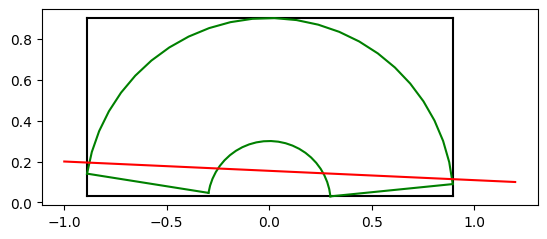

In [8]:
def plot_elements():
    fig, axs = plt.subplots(1)
    # cartesian bounding box 
    axs.plot([le[0], re[0]], [le[1], le[1]],'k')
    axs.plot([le[0], re[0]], [re[1], re[1]],'k')
    axs.plot([le[0], le[0]], [le[1], re[1]],'k')
    axs.plot([re[0], re[0]], [le[1], re[1]],'k')
    
    # the element 
    axs.plot(x_el_in,y_el_in,'g')
    axs.plot(x_el_out,y_el_out,'g')
    axs.plot(x_el_phi0,y_el_phi0,'g')
    axs.plot(x_el_phi1,y_el_phi1,'g')
    
    # a ray 
    axs.plot(x, y,'r')
    axs.set_aspect('equal')
    return fig, axs

plot_elements()    

# slab test

e.g., https://tavianator.com/2022/ray_box_boundary.html

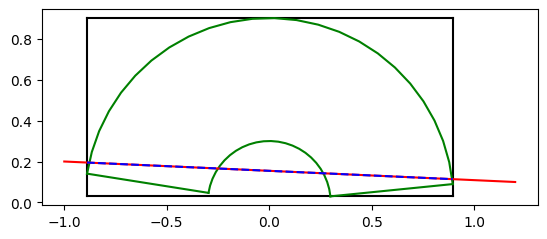

In [9]:

t1 = (le[0] - ray_origin[0])/ray_dir[0]
t2 = (re[0] - ray_origin[0])/ray_dir[0]
tmin = min(t1,t2)
tmax = max(t1,t2)

tmin = max(tmin, min(t1, t2))
tmax = min(tmax, max(t1, t2))

intersects = tmax > tmin

if intersects:
    t_range = np.linspace(tmin, tmax, 25)
    x_intx = ray_origin[0] + t_range * ray_dir[0]
    y_intx = ray_origin[1] + t_range * ray_dir[1]
    
    f, axs = plot_elements()    
    axs.plot(x_intx, y_intx,'--b')

### additional intersections?


in 3d, 3 primitive shapes define the boundaries of a spherical volume element

* ray-sphere for rmin, rmax. 
* ray-plane for the fixed phi at phi0, phi1
* ray-cone for fixed theta at theta1, thetat2 

so that's additional 6 intersection tests, some of which may have multiple intersections (ray-sphere will have 0, 1, or 2, ray-cone can have 0, 1, 2, and 2+imaginary ghost-cone intersection, ray-plane is 0, 1 or infinite). 

So kinda a lot to do... 

modifying the initial glsl implementations i had:

In [10]:
def get_ray_plane_intersection(p_normal, p_constant, ray_origin, ray_dir):
    # intersection with a plane defined by constant phi
    n_dot_u = np.dot(p_normal, ray_dir)
    n_dot_ro = np.dot(p_normal, ray_origin)

    # ray is parallel to plane with infinite or no intersections 
    if (n_dot_u == float(0.0)):
        return False, []    

    # otherwise, the the intersection is at
    t_point = [np.asarray([(p_constant - n_dot_ro) / n_dot_u,]),]
    return True, t_point

In [11]:
def get_ray_sphere_intersection(r, ray_origin, ray_dir):
    # intersection with a sphere defined by constant r
    dir_dot_dir = np.dot(ray_dir, ray_dir)
    ro_dot_ro = np.dot(ray_origin, ray_origin)
    dir_dot_ro = np.dot(ray_dir, ray_origin)
    rsq = r * r

    a_2 = 2.0 * dir_dot_dir
    b = 2.0 * dir_dot_ro
    c =  ro_dot_ro - rsq
    determinate = b*b - 2.0 * a_2 * c
    
    if determinate < 0.0:
        return False, []    
    elif determinate == 0.0:
        t_point = -b / a_2;
        return True, [t_point,]
    else:
        t_point1 = (-b - np.sqrt(determinate))/ a_2
        t_point2 = (-b + np.sqrt(determinate))/ a_2
        return True, [t_point1, t_point2]    
    

In [15]:
def get_ray_cone_intersection(theta, ray_origin, ray_dir):
    # intersection with a cone defined by constant theta
    
    if theta > np.pi/2.0:
        # if theta is past PI/2, the cone will point in negative z and the
        # half angle should be measured from the -z axis, not +z.
        vhat = np.array([0.0, 0.0, -1.0])
        costheta = np.cos(np.pi - theta)  
    else:    
        vhat = np.array([0.0, 0.0, 1.0])
        costheta = np.cos(theta)
    
    cos2t = costheta **2 
    # note: theta = PI/2.0 is well defined. determinate = 0 in that case and
    # the cone becomes a plane in x-y.

    dir_dot_vhat = np.dot(ray_dir, vhat)
    dir_dot_dir = np.dot(ray_dir, ray_dir)
    ro_dot_vhat = np.dot(ray_origin, vhat)
    ro_dot_dir = np.dot(ray_origin, ray_dir)
    ro_dot_ro = np.dot(ray_origin, ray_dir)

    a_2 = 2.0*(np.power(dir_dot_vhat, 2) - dir_dot_dir * cos2t)
    b = 2.0 * (ro_dot_vhat * dir_dot_vhat - ro_dot_dir*cos2t)
    c = np.power(ro_dot_vhat, 2) - ro_dot_ro*cos2t
    determinate = b*b - 2.0 * a_2 * c;
    
    if determinate < 0.0:
        # no intersections
        return False, []    
    elif determinate == 0.0:  
        # single intersection
        t_point = -b / a_2
        return True, [t_point,]
    else:    
        # 2 intersections. But note that:
        # note: it is also possible to have real solutions that intersect the shadow cone
        # and not the actual cone. those values will fail the bounds checks for
        # interesecting the volume so no special treatment is needed.
        t_point1 = (-b - np.sqrt(determinate))/ a_2
        t_point2 = (-b + np.sqrt(determinate))/ a_2;
        return True, [t_point1, t_point2]

So... let's calculate all those intersections. Remember -- still doing this in 3D here, the plots are just 2Dish enough to make sense.

In [16]:
sphere_int_1 = get_ray_sphere_intersection(r0, ray_origin, ray_dir)
sphere_int_2 = get_ray_sphere_intersection(r1, ray_origin, ray_dir)
sphere_int_1, sphere_int_2

((True, [array([0.75082459]), array([1.26527555])]),
 (True, [array([0.12139064]), array([1.8947095])]))

In [17]:
cone_int_1 = get_ray_cone_intersection(theta0, ray_origin, ray_dir)
cone_int_2 = get_ray_cone_intersection(theta1, ray_origin, ray_dir)
cone_int_1, cone_int_2

((True, [array([2.43079918]), array([-0.41469903])]),
 (True, [array([2.43079918]), array([-0.41469903])]))

Cone intersections will always be null for this notebook, since rays line in the z = 0 plane.

anyway, Using `get_ray_plane_intersection` will require calculating those phi-normal planes first

In [18]:
import numpy as np


def phi_normal_plane(r, theta, phi):
    # simplified from
    # https://github.com/yt-project/yt_idv/blob/3cef5b304a403cec17bd02ba6d11bb9b934c98db/yt_idv/scene_data/_geometry_utils.py
    # for use with a single plane    

    # get the cartesian values of the coordinates
    z = r * np.cos(theta)
    r_xy = r * np.sin(theta)
    x = r_xy * np.cos(phi)
    y = r_xy * np.sin(phi)
    xyz = np.concatenate([x, y, z])    

    # construct the plane
    z_hat = np.array([0, 0, 1])
    normal_vec = np.cross(xyz, z_hat)    
    d = np.dot(normal_vec, xyz) # find any point in the plane.

    plane = [normal_vec, float(d)]
    return plane 

p0 = phi_normal_plane(r0, theta0, phi0) # r, theta values should not matter
p1 = phi_normal_plane(r0, theta0, phi1) # r, theta values should not matter

In [19]:
plane_1 = get_ray_plane_intersection(p0[0], p0[1], ray_origin, ray_dir)
plane_2 = get_ray_plane_intersection(p1[0], p1[1], ray_origin, ray_dir)
plane_1, plane_2

((True, [array([2.062188])]), (True, [array([-0.3688884])]))

In [20]:
all_t_vals = plane_1[1] + plane_2[1] + cone_int_1[1] + cone_int_2[1] + sphere_int_1[1] + sphere_int_2[1]
all_t_vals = np.concatenate(all_t_vals)
all_t_vals

array([ 2.062188  , -0.3688884 ,  2.43079918, -0.41469903,  2.43079918,
       -0.41469903,  0.75082459,  1.26527555,  0.12139064,  1.8947095 ])

In [21]:
new_t = [t for t in all_t_vals if t > tmin and t<tmax]

In [22]:
new_t

[0.750824590659408,
 1.2652755541286511,
 0.12139064033817637,
 1.8947095044498827]

### tricky edge cases????

`new_t` will be intersections falling within the bounding box (and will always be >0), but its length may vary:

In [23]:
len_new_t = len(new_t)
if len_new_t == 0:
    # intersects bounding box, but not actual element. 
    # neglecting infinite intersections if ray is on the fixed phi-plane... 
    intersects = False
elif len_new_t == 1: 
    # intersects exactly once, ray hits the cusp of the outer radius sphere
    # just drop it for now
    intersects = False
elif len_new_t not in (2, 4): 
    raise RuntimeError("should only be 2 or 4 at this point") 

# 4 intersections is hard... 

if intersects:
    if len_new_t == 2:
        # trivial
        # new_t guaranteed to be positive!
        # if 4 intersections, need to sort
        new_tmin = min(new_t)
        new_tmax = max(new_t)
        new_t = [new_tmin, new_tmax]
    elif len_new_t == 4:
        # a sort to implement in glsl, this is probably not as efficient as it could be, 
        # but it will work.
        full_max = np.max(new_t)
        full_min = np.min(new_t)        

        # store the other 2 points 
        mid_ts = np.full((2,), -1.0)            
        i_mid = 0
        for i in range(4):
            if new_t[i] > full_min and new_t[i] < full_max:                
                mid_ts[i_mid] = new_t[i]
                i_mid += 1
        mid_min = np.min(mid_ts)
        mid_max = np.max(mid_ts)
        
        new_t = np.array([full_min, mid_min, mid_max, full_max])
            
    print(new_t)

[0.12139064 0.75082459 1.26527555 1.8947095 ]


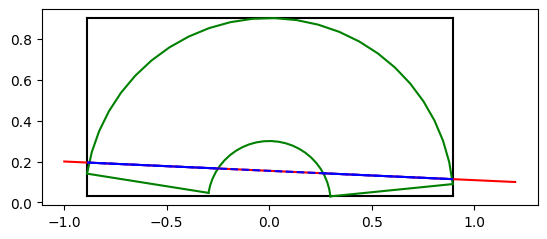

In [24]:
if intersects:
    f, axs = plot_elements()    
    axs.plot(x_intx, y_intx,'--b')

    
    t_range = np.linspace(new_t[0], new_t[1], 25)    
    x_intx_n = ray_origin[0] + t_range * ray_dir[0]
    y_intx_n = ray_origin[1] + t_range * ray_dir[1]
    axs.plot(x_intx_n, y_intx_n,'b')

    if len_new_t == 4: 
        t_range = np.linspace(new_t[2], new_t[3], 25)    
        x_intx_n = ray_origin[0] + t_range * ray_dir[0]
        y_intx_n = ray_origin[1] + t_range * ray_dir[1]
        axs.plot(x_intx_n, y_intx_n,'b')

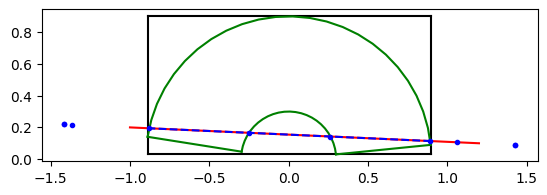

In [25]:
# let's also plot all the t values, just to see where they would fall
if intersects:
    f, axs = plot_elements()    
    axs.plot(x_intx, y_intx,'--b')
    
    for tval in all_t_vals:           
        x_intx_t = ray_origin[0] + tval * ray_dir[0]
        y_intx_t = ray_origin[1] + tval * ray_dir[1]
        axs.plot(x_intx_t, y_intx_t,'.b')
